## Step 1 -- import necessary libraries

In [71]:
import importlib

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skpp

import dask.dataframe as dd

import os # os.path
import datetime

%matplotlib notebook
from matplotlib import pyplot as plt
from numpy import array
from tensorflow.keras.activations import relu, softsign
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, TimeDistributed, Dropout
from tensorflow.keras.models import Sequential
import tensorflow as tf

%load_ext tensorboard

import foresight.backtesting
import foresight.data_functions as fx_df
import foresight.model
import foresight.util as fxu

importlib.reload(fx_df)
importlib.reload(fxu)
importlib.reload(foresight.model)
importlib.reload(foresight.backtesting)

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
mixed_precision.set_policy(policy)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## 2.1 Specify the path of the source data

In [2]:
# src = '/var/local/foresight/timeseries/EURGBP-2016-01.pp1.xz'
src = "/var/local/foresight/timeseries/EURGBP-2017-1-6.csv"

### 2.1.1 Setup model parameters

In [95]:
scaler_type = "MinMaxScaler"  # [MinMaxScaler, None]
sample_time = "5T"  # T=minutes
seq_len = 12  # 1 hours
n_vars = 1
num_outs = 1  # number of future outputs to forecast
Transform = "LogDiff"  # [Diff, LogDiff, None]
model_name = '0003d_6-120_LSTM_5minData_1h_mae'
models_base_path = '/var/local/foresight/models/Keras_Models/'
model_path = models_base_path + model_name

model_LSTM_units = 120

### 2.1.2 Setup training parameters

In [96]:
training_batch_size = 64
training_epochs = 10000
training_dropoff = 0.20
training_loss = 'mae' # ['mae', 'mse', 'mape']
training_optimizer = 'nadam' # ['adam', 'nadam', ...] (see tf docs)

# 3 Prepare Data

## 3.1 Import the data

1. Load the data into a dataframe
2. Specify the column names
3. Convert the date field into the correct datetime64 object

In [5]:
data_raw = fx_df.GetTickdataDataframe(src, date_format_string='%m/%d/%Y %H:%M:%S.%f')

## 3.2 Clean up the data

In [6]:
if not (fxu.VarExists(sample_time)):
    raise RuntimeError("'sample_time' must be defined")

data = fx_df.clean_data(
    data_raw,
    remove_duplicates=True,
    sample_frequency=sample_time,
    sample_type="nearest",
    remove_weekends=True,
)

## 3.3 Create transformer object

In [7]:
data_txr = fx_df.Data_Transformer(Transform, 2, scaler_type)

## 3.4 Extract data as an np.ndarray

In [85]:
data_arr = data["bid"].to_numpy()

# 4 Prepare Keras model

In [97]:
def BuildModel():
    if not (fxu.VarExists(seq_len)):
        raise RuntimeError("'seq_len' must be defined")

    if not (fxu.VarExists(n_vars)):
        raise RuntimeError("'n_vars' must be defined")
    
    # TODO: fix this somehow
    output_columns = [0]

    Activation_Function = "tanh"  # ['tanh', 'softsign', 'relu', 'elu', 'LeakyReLU']

    _metrics = [tf.keras.metrics.MeanAbsoluteError(name='mae'),
                tf.keras.metrics.MeanAbsolutePercentageError(name='mape'), 
                tf.keras.metrics.MeanSquaredError(name='mse'), 
#                tf.keras.metrics.RootMeanSquaredError(name='rmse'), 
#                tf.keras.metrics.LogCoshError(name='logcosh'), 
#                tf.keras.metrics.MeanSquaredLogarithmicError(name='msle')
               ]
    
    LSTM_model = Sequential()

#    LSTM_model.add(LSTM(100, activation=Activation_Function, return_sequences=True, input_shape=(seq_len, n_vars), dropout=training_dropoff))
    LSTM_model.add(LSTM(model_LSTM_units, activation=Activation_Function, return_sequences=True, input_shape=(seq_len, n_vars), dropout=0))
    LSTM_model.add(LSTM(model_LSTM_units, activation=Activation_Function, return_sequences=True, dropout=training_dropoff))
    LSTM_model.add(LSTM(model_LSTM_units, activation=Activation_Function, return_sequences=True, dropout=training_dropoff))
    LSTM_model.add(LSTM(model_LSTM_units, activation=Activation_Function, return_sequences=True, dropout=training_dropoff))
    LSTM_model.add(LSTM(model_LSTM_units, activation=Activation_Function, return_sequences=True, dropout=training_dropoff))
    LSTM_model.add(LSTM(model_LSTM_units, activation=Activation_Function, return_sequences=False, dropout=training_dropoff))
    if training_dropoff:
        LSTM_model.add(Dropout(training_dropoff))
    LSTM_model.add(Dense(len(output_columns)))
    # model.compile(loss= 'mae' , optimizer= 'nadam' )
    LSTM_model.compile(loss= training_loss , optimizer= training_optimizer, metrics = _metrics ) # 'adam'
    # model.build()
    print(LSTM_model.summary())
    
    return LSTM_model

# 5 Create foresight.Model object

In [98]:
fx_model = foresight.model.Model(
    model=BuildModel(),
    data=data_arr,
    data_freq=pd.Timedelta(sample_time),
    seq_len=seq_len,
    scaler=None,
    forecast_horizon=1,
    data_transform=data_txr,
    stationary_transform="LogDiff",
    max_training_data_factor=2.0,
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 12, 120)           58560     
_________________________________________________________________
lstm_13 (LSTM)               (None, 12, 120)           115680    
_________________________________________________________________
lstm_14 (LSTM)               (None, 12, 120)           115680    
_________________________________________________________________
lstm_15 (LSTM)               (None, 12, 120)           115680    
_________________________________________________________________
lstm_16 (LSTM)               (None, 12, 120)           115680    
_________________________________________________________________
lstm_17 (LSTM)               (None, 120)               115680    
_________________________________________________________________
dropout (Dropout)            (None, 120)              

# 6 Fit timeseries Model

## 6.1 Setup callbacks

Callbacks are used here for 

- saving checkpoint info to disk to allow resuming the training of a model if it becomes interrupted
- saving tensorboard log information for visualization

### 6.1.1 Parameters

In [99]:
# Checkpoint parameters
checkpoint_file = model_path + '/checkpoints/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_file)
cp_freq_in_epochs = 10

# Tensorboard Parameters
tb_path = model_path + '/logs'
logdir = os.path.join(tb_path, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

### 6.1.2 Create Checkpoint Callback

In [100]:
cp_approx_batches_per_epoch = (data_arr.shape[0] - seq_len)/training_batch_size
cp_save_freq = int(cp_approx_batches_per_epoch * cp_freq_in_epochs)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_file,
    save_weights_only=True,
    save_freq=cp_save_freq,
)

### 6.1.3 Create Tensorboard Callback

In [101]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=10)

## 6.2 Setup model directory and load checkpoint data, if available

In [102]:
if not os.path.exists(checkpoint_dir):
    from pathlib import Path
    Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
    
if os.path.isfile(checkpoint_file + '.index'):
    fx_model._model.load_weights(checkpoint_file)
    print('Loaded saved weights from checkpoint file')
else:
    fx_model._model.save_weights(checkpoint_file)
    print('Initialized new checkpoint file')


Initialized new checkpoint file


## 6.3 Fit the model

## 6.3.1 Start tensorboard

In [103]:
#%tensorboard --logdir var/local/foresight/models/Keras_Models/0001_6-LSTM_5minData_3h/logs
%tensorboard --logdir $tb_path --bind_all
#from tensorboard import notebook
#notebook.list()
#notebook.display(port=6006)

In [ ]:
_ = fx_model.Fit(
    batch_size=training_batch_size,
    epochs=training_epochs,
    train_frac=5 / 5,
    valid_frac=0 / 3,
    verbose=1,
    validate_model=False,
    print_test_stat=False,
    callbacks=[cp_callback, tb_callback],
#    callbacks=[cp_callback],
)

Number of training samples:  8314
Number of test samples:  0
Number of validation samples:  8314
Epoch 1/10000
130/130 [==============================] - 2s 18ms/step - loss: 0.267610 - mae: 0.267619 - mape: 265.605652 - mse: 0.122265
Epoch 2/10000
130/130 [==============================] - 2s 15ms/step - loss: 0.267609 - mae: 0.267603 - mape: 249.654510 - mse: 0.122180
Epoch 3/10000
130/130 [==============================] - 2s 15ms/step - loss: 0.267448 - mae: 0.267437 - mape: 277.842865 - mse: 0.122010
Epoch 4/10000
130/130 [==============================] - 2s 15ms/step - loss: 0.267520 - mae: 0.267511 - mape: 237.194321 - mse: 0.121993
Epoch 5/10000
130/130 [==============================] - 2s 15ms/step - loss: 0.267538 - mae: 0.267544 - mape: 239.383163 - mse: 0.122096
Epoch 6/10000
130/130 [==============================] - 2s 15ms/step - loss: 0.267436 - mae: 0.267445 - mape: 249.849030 - mse: 0.122167
Epoch 7/10000
130/130 [==============================] - 2s 15ms/step - los

In [ ]:
#fx_model._model.save(models_path + model_name)

# 6 Backtest the model

In [112]:
importlib.reload(foresight.backtesting)
importlib.reload(fx_df)
import foresight.tradingRules

importlib.reload(foresight.tradingRules)

print(type(fx_model))
_trading_rules = foresight.tradingRules.BasicTradingRules(
    trade_size=1_000, stop_loss=0.00015, take_profit=0.00025, min_change=0.00010
)
backtester = foresight.backtesting.Backtester(
    model=fx_model, retraining_freq=pd.Timedelta("2D"), trading_rules=_trading_rules, initial_money=1_000,
)

<class 'foresight.model.Model'>
Restarting every 576 datapoints
New backtester created!!


In [110]:
bt_src = "/var/local/foresight/timeseries/EURGBP-2017-7-13.csv"
forecast_data = fx_df.GetTickdataDataframe(bt_src, date_format_string='%m/%d/%Y %H:%M:%S.%f')

In [113]:
backtester.Reset_Model()
bids, bid_hats = backtester.Backtest(
    forecast_data,
    initial_retraining=1,
    trading_rules = _trading_rules,
    retrain_batch_size=4 * training_batch_size,
    retrain_epochs=150,
    retrain_verbose=True,
)

Retraining every 576 points
Number of training samples:  10042
Number of test samples:  0
Number of validation samples:  10042
Epoch 1/150
157/157 [==============================] - 2s 15ms/step - loss: 0.026445 - mae: 0.026445 - mape: 130.622742 - mse: 0.008324
Epoch 2/150
157/157 [==============================] - 2s 14ms/step - loss: 0.026550 - mae: 0.026551 - mape: 128.864288 - mse: 0.007942
Epoch 3/150
157/157 [==============================] - 2s 15ms/step - loss: 0.025001 - mae: 0.025001 - mape: 118.973160 - mse: 0.007170
Epoch 4/150
157/157 [==============================] - 2s 15ms/step - loss: 0.025031 - mae: 0.025030 - mape: 108.676819 - mse: 0.007280
Epoch 5/150
157/157 [==============================] - 2s 15ms/step - loss: 0.024871 - mae: 0.024871 - mape: 111.022491 - mse: 0.007128
Epoch 6/150
157/157 [==============================] - 2s 15ms/step - loss: 0.024352 - mae: 0.024351 - mape: 107.783089 - mse: 0.006526
Epoch 7/150
157/157 [==============================] - 2s

KeyboardInterrupt: 

In [ ]:
bids_ = bids.reshape(1,-1)
print(bids.shape)
print(bids.flatten())

#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

d_ = pd.DataFrame(bids, columns=['bid_actual'])
d_['bid_forecast'] = bid_hats
d_['id'] = d_.index
print(d_.melt(value_vars=['bid_actual', 'bid_forecast'], id_vars=['id']))
sns.set(rc={'figure.figsize':(30, 20)})
#sns.lineplot(x='id', y='value', hue='variable', data=d_[100:200].melt(value_vars=['bid_actual', 'bid_forecast'], id_vars=['id']))
plt.plot(x1=d_['id'], y1=d_['bid_actual'], x2=d_['id'], y2=d_['bid_forecast'])
#print(bids - bid_hats)

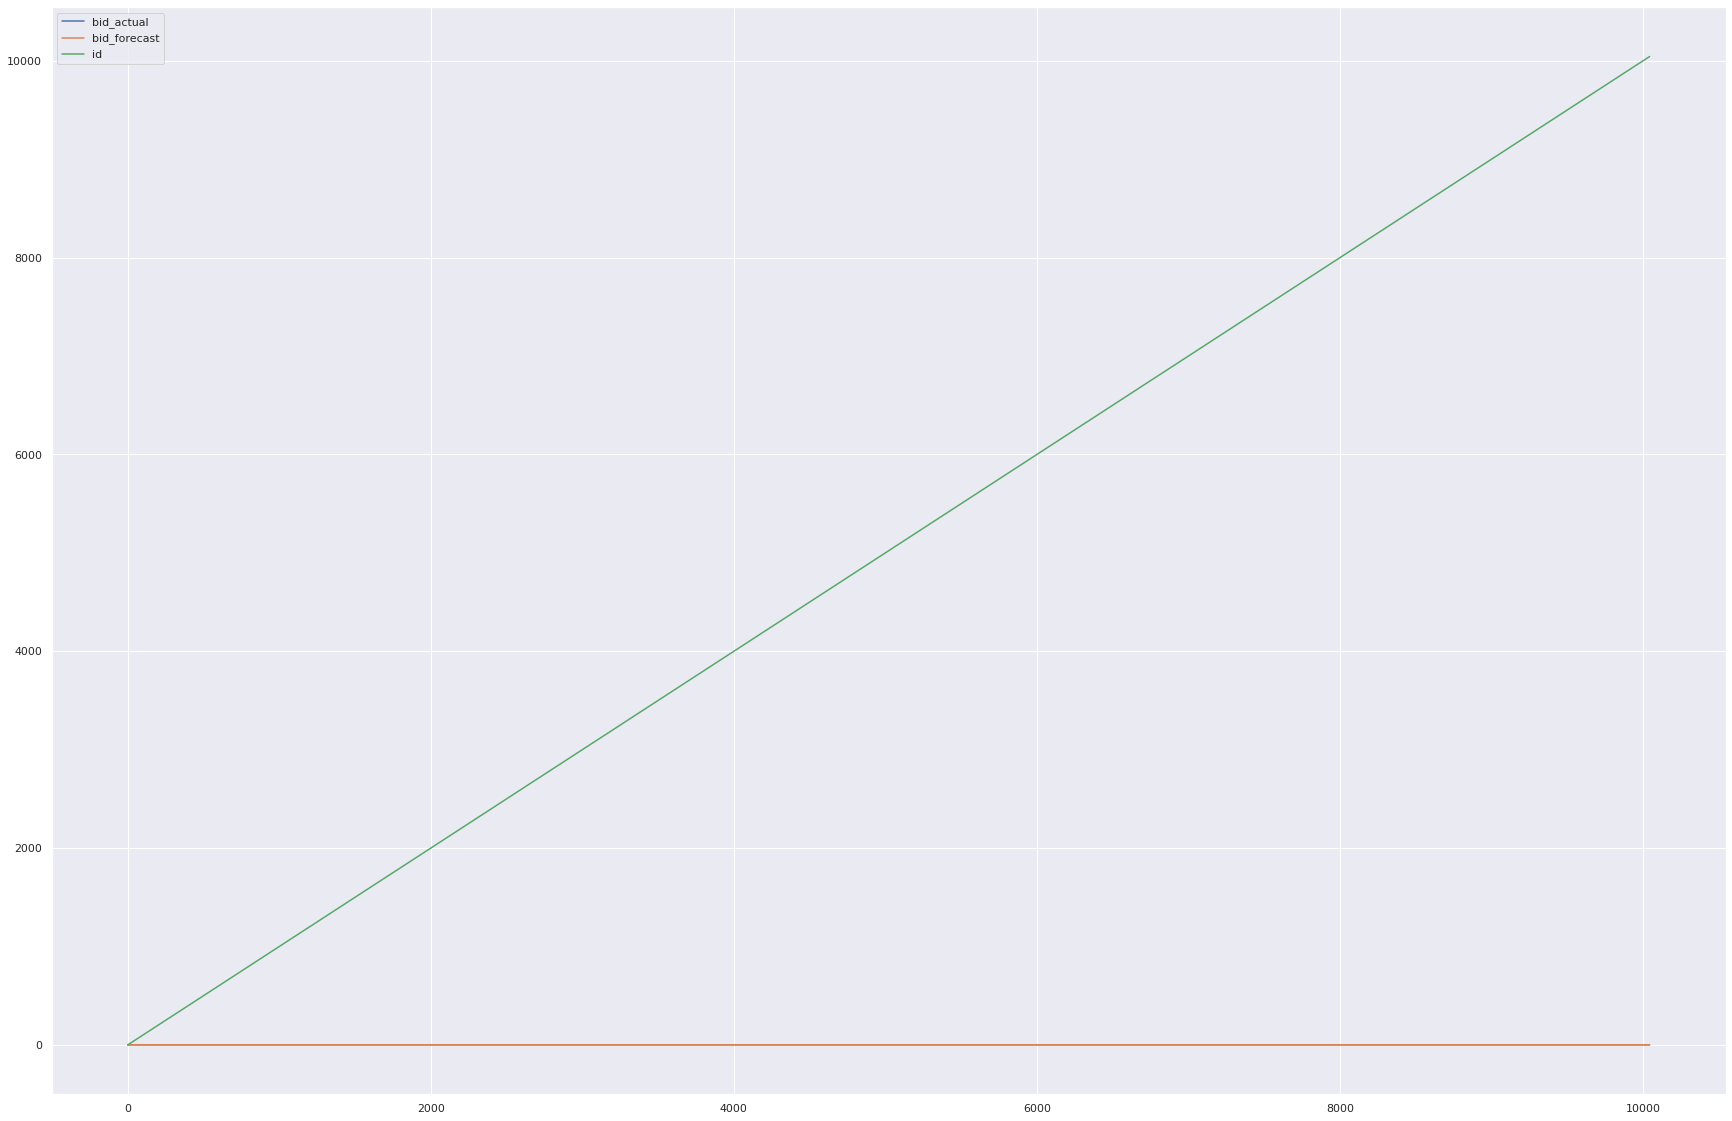

In [82]:
d_.plot()